In [1]:
import pandas as pd

df = pd.read_csv('data/UDsales_forcast.csv')
df.head(10)

,date,count,funds,is_holiday,weekday,is_school_holiday,max_temp,min_temp,rainfall,solar
0,2022-07-04,1004,25294.82,0,0,1,14.0,11.4,0.0,5.0
1,2022-07-05,1647,35762.88,0,1,1,13.5,10.1,12.0,4.7
2,2022-07-06,2418,38736.68,0,2,1,19.0,10.9,10.0,10.9
3,2022-07-07,727,34504.45,0,3,1,19.1,11.9,0.0,14.1
4,2022-07-08,4417,52519.30,0,4,1,19.2,9.6,0.0,14.2
5,2022-07-09,3028,25652.15,0,5,1,18.8,7.0,0.0,14.2
6,2022-07-10,2303,25455.29,0,6,1,20.5,5.2,0.0,12.7
7,2022-07-11,1288,22235.53,0,0,0,20.2,4.2,0.0,11.0
8,2022-07-12,940,16772.46,0,1,0,19.6,5.8,0.0,10.6
9,2022-07-13,380,12114.32,0,2,0,19.3,7.6,4.0,13.8


In [2]:
df.shape

(1105, 10)

In [3]:
df.dtypes

date                  object
count                  int64
funds                float64
is_holiday             int64
weekday                int64
is_school_holiday      int64
max_temp             float64
min_temp             float64
rainfall             float64
solar                float64
dtype: object

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date                 datetime64[ns]
count                         int64
funds                       float64
is_holiday                    int64
weekday                       int64
is_school_holiday             int64
max_temp                    float64
min_temp                    float64
rainfall                    float64
solar                       float64
dtype: object

In [50]:
df.to_csv('alldf_forcast.csv')

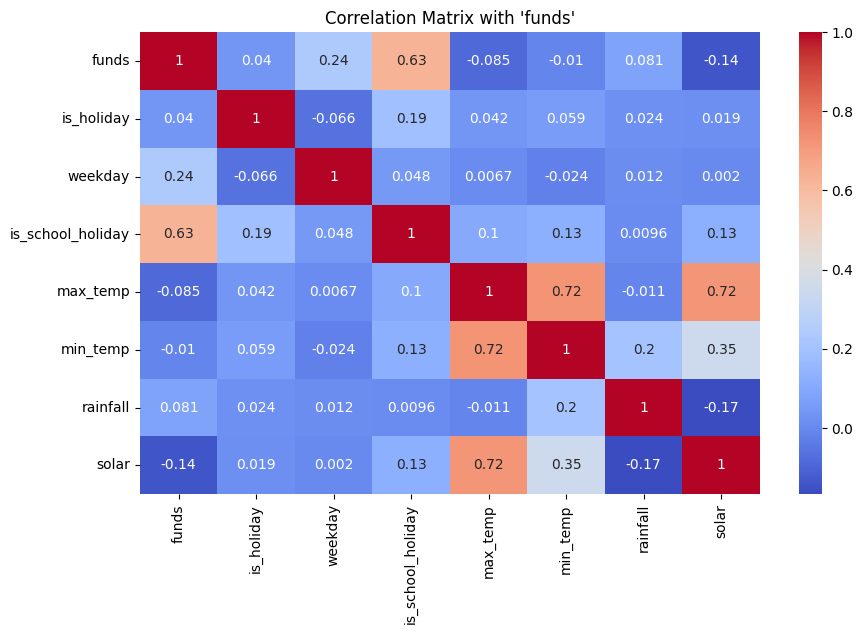

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = df.corr(numeric_only=True)  # include only numeric columns

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix with 'funds'")
plt.show()

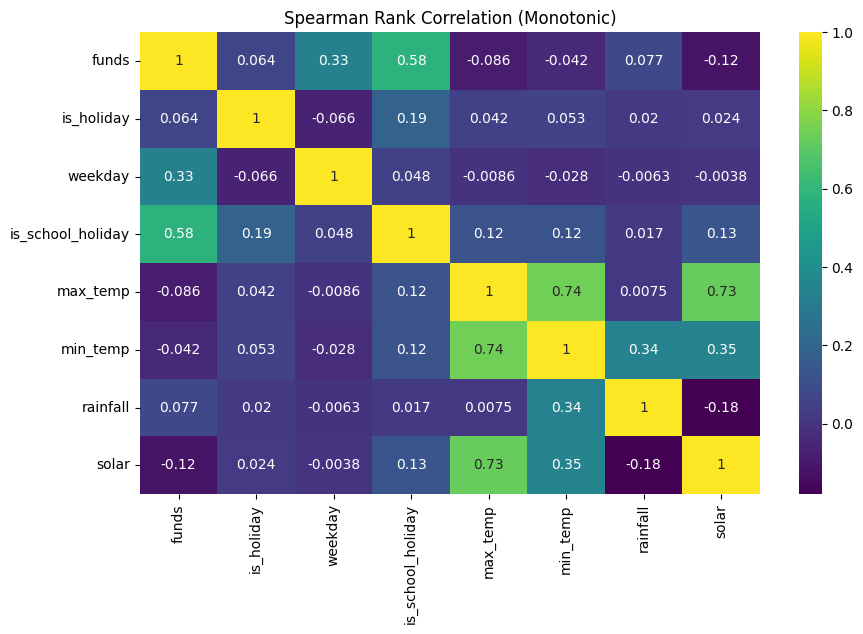

In [7]:
corr_spearman = df.corr(method='spearman', numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_spearman, annot=True, cmap='viridis')
plt.title("Spearman Rank Correlation (Monotonic)")
plt.show()

In [8]:
from sklearn.feature_selection import mutual_info_regression

X = df.drop(columns=['date', 'funds'])
y = df['funds']

# MI works only with numeric input
mi = mutual_info_regression(X, y, discrete_features='auto')

mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print(mi_series)

is_school_holiday    0.209264
weekday              0.153778
min_temp             0.039582
solar                0.026571
rainfall             0.002491
is_holiday           0.000000
max_temp             0.000000
dtype: float64


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop(columns=['date', 'funds'])
y = df['funds']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation metrics
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 8371.396056832169
R² Score: 0.5221370302869461


In [19]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation metrics
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 10355.217762486518
R² Score: 0.2688170231570808


In [20]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,     # number of trees
    max_depth=None,       # you can limit tree depth to prevent overfitting
    random_state=42,      # reproducibility
    n_jobs=-1             # use all CPU cores
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation metrics
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

RMSE: 7280.0788279081235
R² Score: 0.6386069777481778
is_school_holiday    0.377337
weekday              0.175377
solar                0.169282
min_temp             0.115096
max_temp             0.103402
rainfall             0.041573
is_holiday           0.017934
dtype: float64


In [23]:
import sys
!{sys.executable} -m pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df1 = df.copy()
df1 = df1.set_index('date')
y = df1['funds']

model = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit()

forecast = results.forecast(steps=30)  # forecast next 30 days
print(forecast)

/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2025-07-13    46908.700764
2025-07-14    46373.972327
2025-07-15    45783.642640
2025-07-16    43717.992705
2025-07-17    43584.342929
2025-07-18    47459.532901
2025-07-19    55525.341319
2025-07-20    51513.563675
2025-07-21    47164.866557
2025-07-22    45946.233250
2025-07-23    44083.754494
2025-07-24    43789.120605
2025-07-25    47669.997286
2025-07-26    57918.929338
2025-07-27    53196.624697
2025-07-28    48178.761159
2025-07-29    46845.587797
2025-07-30    45014.868694
2025-07-31    44690.957834
2025-08-01    48572.029533
2025-08-02    59196.153521
2025-08-03    54351.419213
2025-08-04    49218.338571
2025-08-05    47865.412857
2025-08-06    46040.134276
2025-08-07    45711.175110
2025-08-08    49592.274633
2025-08-09    60280.942997
2025-08-10    55415.144750
2025-08-11    50262.241710
Freq: D, Name: predicted_mean, dtype: float64


In [26]:
import sys
!{sys.executable} -m pip install prophet

In [30]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

df_prophet = df[['date', 'funds']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

train = df_prophet.iloc[:-30]
test = df_prophet.iloc[-30:]
# Prepare for Prophet
train_prophet = train[['ds', 'y']]
test_prophet = test[['ds', 'y']]


model = Prophet(daily_seasonality=True, yearly_seasonality=True)

model.fit(train_prophet)

# Make future DataFrame for next 30 days (same length as test set)
future = model.make_future_dataframe(periods=30)

# Get forecast
forecast = model.predict(future)

# Filter only the last 30 days of forecast
forecast_eval = forecast.iloc[-30:]

y_true = test_prophet['y'].values
y_pred = forecast_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mae)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

01:17:35 - cmdstanpy - INFO - Chain [1] start processing
01:17:35 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 94.46
MAE: 8922.60


In [34]:
print(y_true - y_pred)

[ -8118.71820123   3129.20697089   1259.43394835  -5637.68289594
  -6326.47381248  -9887.81740672 -13218.78483758 -10189.2588463
   1401.06967755   5091.64866038  -4289.72235419 -10237.78309705
 -12470.74937879 -12086.81586176 -11958.02216732  -9169.38969752
    783.57538294  15830.59682589   4441.99057261  10384.05978154
   1250.40788568   3090.89566428  -2934.99353464   5031.7339931
  21782.35492072  20422.77355194  15794.55014277  15749.36410535
  17372.30387633   8335.92359832]


In [35]:
import pandas as pd

# Summer holidays are longer
summer_breaks = pd.DataFrame({
    'holiday': 'school_holiday',
    'ds': pd.to_datetime(['2022-12-10', '2023-12-09', '2024-12-14']),
    'lower_window': 0,
    'upper_window': 41
})

# All other holidays
other_breaks = pd.DataFrame({
    'holiday': 'school_holiday',
    'ds': pd.to_datetime([
        '2022-04-02', '2022-06-25', '2022-09-17',
        '2023-04-01', '2023-06-24', '2023-09-16',
        '2024-03-29', '2024-06-22', '2024-09-14',
        '2025-04-05', '2025-06-28', '2025-09-20'
    ]),
    'lower_window': 0,
    'upper_window': 13
})

qld_school_holidays = pd.concat([summer_breaks, other_breaks])

qld_public_holidays = pd.DataFrame({
    'holiday': 'public_holiday',
    'ds': pd.to_datetime([
        '2023-01-01', '2023-04-25', '2023-05-01', '2023-10-02',
        '2024-01-01', '2024-04-25', '2024-05-06', '2024-10-07',
        '2025-01-01', '2025-04-25', '2025-05-05', '2025-10-06'
    ]),
    'lower_window': 0,
    'upper_window': 0  # usually 1-day effect
})

combined_holidays = pd.concat([qld_school_holidays, qld_public_holidays])

df_prophet = df[['date', 'funds']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['is_weekend'] = df_prophet['ds'].dt.weekday >= 5  # Saturday=5, Sunday=6
df_prophet['is_weekend'] = df_prophet['is_weekend'].astype(int)  # Convert to 0/1

train = df_prophet.iloc[:-30]
test = df_prophet.iloc[-30:]

train_prophet = train[['ds', 'y', 'is_weekend']]
test_prophet = test[['ds', 'y', 'is_weekend']]

model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=True,
    holidays=combined_holidays
)

model.add_regressor('is_weekend')
model.fit(train_prophet)

future = model.make_future_dataframe(periods=30)
future['is_weekend'] = (future['ds'].dt.weekday >= 5).astype(int)

forecast = model.predict(future)

# Filter only the last 30 days of forecast
forecast_eval = forecast.iloc[-30:]

y_true = test_prophet['y'].values
y_pred = forecast_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

01:52:34 - cmdstanpy - INFO - Chain [1] start processing
01:52:34 - cmdstanpy - INFO - Chain [1] done processing


MAE: 5375.95
RMSE: 6587.03


In [36]:
print(y_true - y_pred)

[-8096.77743131  1320.26754507   570.56186268 -3009.045899
 -2660.77809397 -5902.11016197 -8539.12550985 -5871.27977483
  4142.76973517  9135.03168882  3173.09451987 -1720.71927146
 -3704.45298633 -2786.61570003 -3268.12550178  -164.08624527
  8767.48662601 13989.75054131 -1050.96604286  6024.83634791
 -3062.21395013  1366.18004143   685.12645204  5540.22975368
 12484.29713774 11993.62052735  6639.89476855  5426.95435779
  9566.82276478 10615.3639474 ]


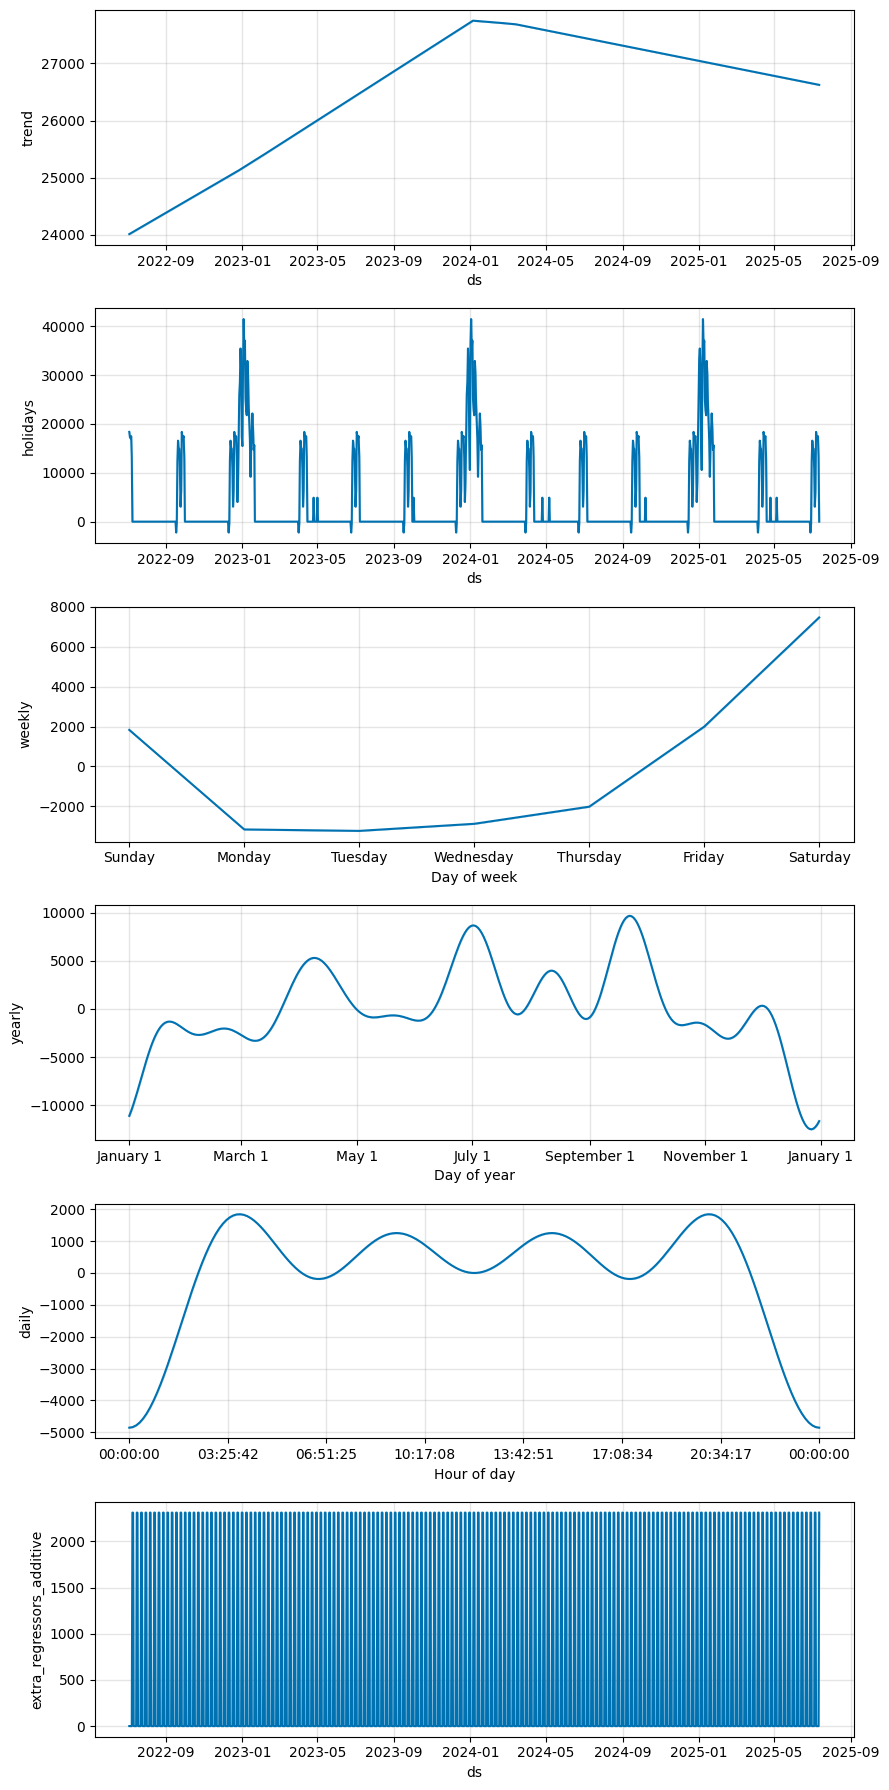

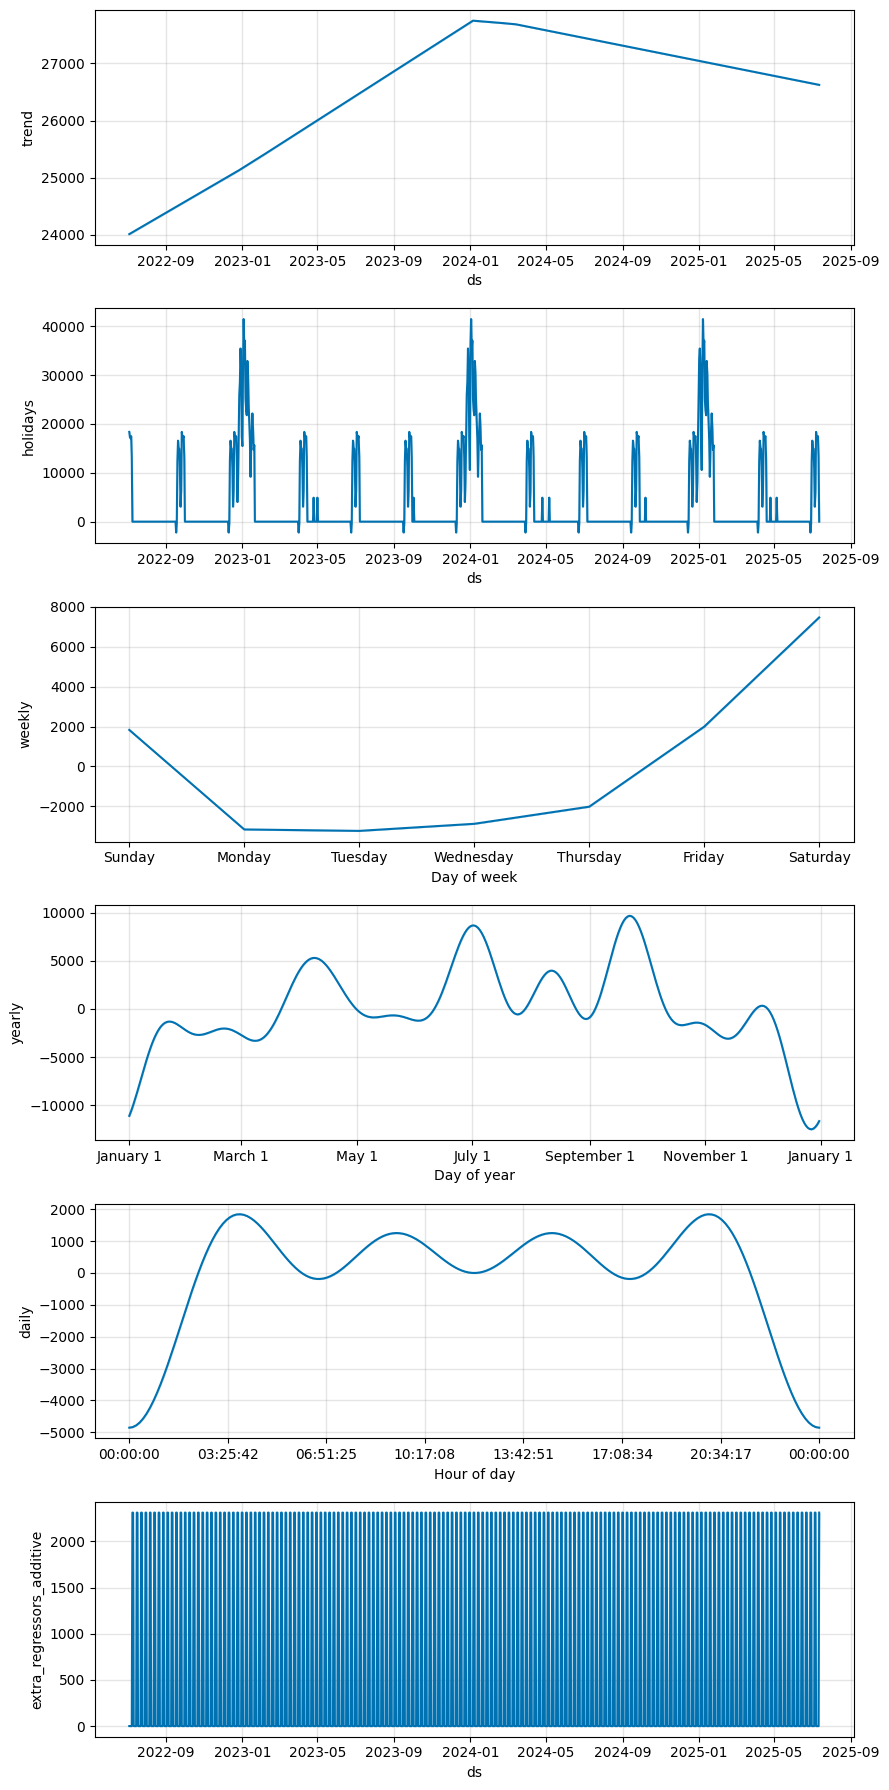

In [37]:
model.plot_components(forecast)

In [44]:
# 复制 forecast 最后 30 天
forecast_eval = forecast.iloc[-30:].copy()

# 构建主对比表
comparison_df = pd.DataFrame({
    'date': forecast_eval['ds'].values,
    'yhat_predicted': forecast_eval['yhat'].values,
    'y_actual': test_prophet['y'].values
})


comparison_df['is_weekend'] = comparison_df['date'].dt.weekday >= 5
comparison_df['is_weekend'] = comparison_df['is_weekend'].astype(int)

# 加入 school/public holiday 标记
# 如果某天在 holidays 的影响窗口范围内，则视为 holiday
holiday_effect_dates = []

for _, row in combined_holidays.iterrows():
    start = row['ds'] + pd.Timedelta(days=row['lower_window'])
    end = row['ds'] + pd.Timedelta(days=row['upper_window'])
    holiday_effect_dates.extend(pd.date_range(start=start, end=end))

holiday_effect_dates = pd.Series(holiday_effect_dates).drop_duplicates()

# 标记该日是否为 holiday
comparison_df['is_school_or_public_holiday'] = comparison_df['date'].isin(holiday_effect_dates).astype(int)

# 误差列
comparison_df['error'] = comparison_df['yhat_predicted'] - comparison_df['y_actual']
comparison_df['abs_error'] = comparison_df['error'].abs()

# 整理格式
comparison_df = comparison_df.round(2)
comparison_df

,date,yhat_predicted,y_actual,is_weekend,is_school_or_public_holiday,error,abs_error
0,2025-06-13,24611.43,16514.65,0,0,8096.78,8096.78
1,2025-06-14,32839.43,34159.70,1,0,-1320.27,1320.27
2,2025-06-15,27668.95,28239.51,1,0,-570.56,570.56
3,2025-06-16,20868.20,17859.15,0,0,3009.05,3009.05
4,2025-06-17,21329.60,18668.82,0,0,2660.78,2660.78
5,2025-06-18,22239.61,16337.50,0,0,5902.11,5902.11
6,2025-06-19,23666.55,15127.42,0,0,8539.13,8539.13
7,2025-06-20,28255.69,22384.41,0,0,5871.28,5871.28
8,2025-06-21,36620.49,40763.26,1,0,-4142.77,4142.77
9,2025-06-22,31537.02,40672.05,1,0,-9135.03,9135.03
